## Welcome to the `Intro to Segmentation` Workshop!
In this workshop, we'll learn the concept of how to use FCN (Fully convolutional Networks)for Semantic Segmentation  Network models using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define a custom model with pretrained backbone
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Imports

In [ ]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [ ]:
images = np.load('dataset/images.npy').astype(np.uint8)
images = np.moveaxis(images, 1, -1)

labels = np.load('dataset/labels.npy').astype(np.uint8)
labels[labels == 0] = 3
labels[labels == 1] = 0
labels[labels == 2] = 1

print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3000, 80, 160, 3), Label images shape = (3000, 80, 160)


In [ ]:
print(np.unique(labels))
print(((labels == 0).sum() / labels.size) * 100, ((labels == 1).sum() / labels.size) * 100, ((labels == 3).sum() / labels.size) * 100)

[0 1 3]
11.976 4.7369843750000005 83.28701562500001


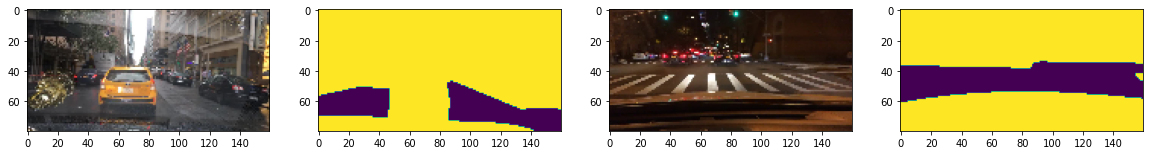

In [ ]:
# plot sample image
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes = axes.flatten()

# plot two random samples of image, label from dataset
rand_idx = np.random.choice(images.shape[0], 2)
axes[0].imshow(images[rand_idx[0]])
axes[1].imshow(labels[rand_idx[0]])
axes[2].imshow(images[rand_idx[1]])
axes[3].imshow(labels[rand_idx[1]])

## Split into Train, validation and test sets

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle
images, labels = shuffle(images, labels)

# split into train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

## Torch dataset class definition

In [ ]:
class BDD100k_dataset(Dataset):
    def __init__(self,  images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        x = self.images[index]
        if self.transform:
            x = self.transform(x)
        y = torch.from_numpy(self.labels[index]).long()
        return x, y

    def __len__(self):
        return self.images.shape[0]

## Torch Datasets and Dataloaders creation

In [ ]:
# necessary image transform i.e. convert to Tensor, normalize
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# create torch dataset for train, validation and test sets
train_dataset = BDD100k_dataset(X_train, y_train, preprocess)
val_dataset = BDD100k_dataset(X_val, y_val, preprocess)
test_dataset = BDD100k_dataset(X_test, y_test, preprocess)
print(f"Len of train_dataset = {len(train_dataset)}, Len of val_dataset = {len(val_dataset)}, Len of test_dataset = {len(test_dataset)}")

NUM_WORKERS = 1 
TEST_BATCH_SIZE  = 32
TRAIN_BATCH_SIZE = 16

# Create loaders for train, validation and testing set
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS)  #, drop_last = True
valid_loader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS) #, drop_last = True
test_loader  = DataLoader(test_dataset,  batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS) #, drop_last = True

Len of train_dataset = 2167, Len of val_dataset = 383, Len of test_dataset = 450


# Network : Define a custom model with pretrained backbone

In [ ]:
from torchvision.models import resnet50

In [ ]:
class FCN_resnet50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # feature extractor
        self.backbone = resnet50(pretrained=True)

        # layer4 of resnet50 has 2048 layers output
        backbone_output_channels = 2048
        # classifier will have 512 layers
        classifier_channels = 512

        # Classifier head
        self.classifier = nn.Sequential(
                nn.Conv2d(backbone_output_channels, classifier_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(classifier_channels),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Conv2d(classifier_channels, num_classes, 1)
                )
    
    def forward(self, x):
        # get input shape for upsampling
        input_shape = x.shape[-2:]

        # pass input through the backbone layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # classifier output shape = (batch_size, num_classes, feat_ext_height, feat_ext_width)
        x = self.classifier(x)

        # upsample the classfier output to input shape
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

# 3. Training : Train and validate model on the custom dataset


Before we train our model, we'll define some helper functions to calculate metric, plot training results etc

## Metric - meanIoU

In [ ]:
class meanIoU:
    """ Class to find the mean IoU using confusion matrix approach """    
    def __init__(self, num_classes):
        self.iou_metric = 0.0
        self.num_classes = num_classes
        # placeholder for confusion matrix on entire dataset
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, y_preds, labels):
        """ Function finds the IoU for the input batch
        and add batch metrics to overall metrics """
        predicted_labels = torch.argmax(y_preds, dim=1)
        batch_confusion_matrix = self._fast_hist(labels.numpy().flatten(), predicted_labels.numpy().flatten())
        self.confusion_matrix += batch_confusion_matrix
    
    def _fast_hist(self, label_true, label_pred):
        """ Function to calculate confusion matrix on single batch """
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist

    def compute(self):
        """ Computes overall meanIoU metric from confusion matrix data """ 
        hist = self.confusion_matrix
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        return mean_iu

    def reset(self):
        self.iou_metric = 0.0
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

## Function to plot training curves

In [ ]:
def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

## Train validate function

In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
def evaluate_model(model, dataloader, criterion, metric_class, device):
    # prepare for inference 
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(NUM_CLASSES)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)                
            y_preds = model(inputs)

            # calculate loss
            loss = criterion(y_preds, labels)
            total_loss += loss.item()

            # update batch metric information            
            metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric

In [ ]:
def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, lr_scheduler = None):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device) 

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 
                        'trainLoss': train_loss, 
                        'validationLoss': validation_loss, 
                        f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"weights/{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

In [ ]:
# device definition
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# training hyperparameters
N_EPOCHS = 5
NUM_CLASSES = 2
MAX_LR = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index = 3)

# create model, optimizer, lr_scheduler and pass to training function
model = FCN_resnet50(num_classes=NUM_CLASSES).to(gpu_device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_loader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

Starting 1 epoch ...


100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


Epoch: 1, trainLoss:0.50317, validationLoss:0.42250, meanIoU: 0.66%
Starting 2 epoch ...


100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch: 2, trainLoss:0.36437, validationLoss:0.33952, meanIoU: 0.69%
Starting 3 epoch ...


100%|██████████| 12/12 [00:01<00:00,  8.07it/s]


Epoch: 3, trainLoss:0.27783, validationLoss:0.37694, meanIoU: 0.70%
Starting 4 epoch ...


100%|██████████| 12/12 [00:01<00:00,  7.91it/s]


Epoch: 4, trainLoss:0.19751, validationLoss:0.36345, meanIoU: 0.73%
Starting 5 epoch ...


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch: 5, trainLoss:0.10834, validationLoss:0.34558, meanIoU: 0.74%


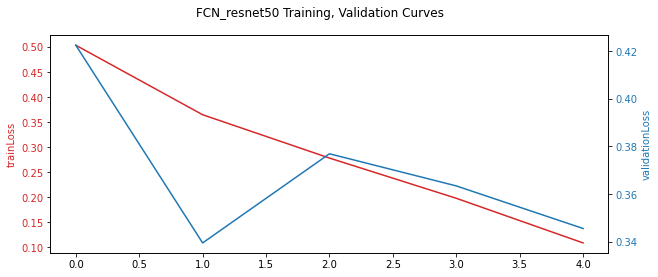

In [ ]:
_ = train_validate_model(model, N_EPOCHS, 'FCN_resnet50', criterion, optimizer, 
                         gpu_device, train_loader, valid_loader, meanIoU, 'meanIoU',
                         lr_scheduler = scheduler)

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
inverse_transform = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

In [ ]:
def visualizePredictions(model : torch.nn.Module, dataSet : Dataset,  
                         device :torch.device, numTestSamples : int):
    """Function visualizes predictions of input model on samples from
    cityscapes dataset provided

    Args:
        model (torch.nn.Module): model whose output we're to visualize
        dataSet (Dataset): dataset to take samples from
        device (torch.device): compute device as in GPU, CPU etc
        numTestSamples (int): number of samples to plot
    """
    model.to(device=device)
    model.eval()

    # predictions on random samples
    testSamples = np.random.choice(len(dataSet), numTestSamples).tolist()
    _, axes = plt.subplots(numTestSamples, 3, figsize=(3*6, numTestSamples * 4))
    
    for i, sampleID in enumerate(testSamples):
        inputImage, gt = dataSet[sampleID]
        inputImage = inputImage.to(device)
        y_pred = torch.argmax(model(inputImage.unsqueeze(0)), dim=1).squeeze(0)
        landscape = inverse_transform(inputImage).permute(1, 2, 0).cpu().detach().numpy()
        # print(inputImage.shape, y_pred.shape, gt.shape, landscape.shape)
        label_class = gt.cpu().detach().numpy()
        label_class_predicted = y_pred.cpu().detach().numpy()
        axes[i, 0].imshow(landscape)
        axes[i, 0].set_title("Landscape")
        axes[i, 1].imshow(label_class)
        axes[i, 1].set_title("Groudtruth Label")
        axes[i, 2].imshow(label_class_predicted)
        axes[i, 2].set_title("Predicted Label")
    plt.show()

In [ ]:
model.load_state_dict(torch.load('weights/FCN_resnet50.pt', map_location=gpu_device))
_, test_metric = evaluate_model(model, test_loader, criterion, meanIoU, gpu_device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

Model has 0.6879113118141602 mean IoU in test set


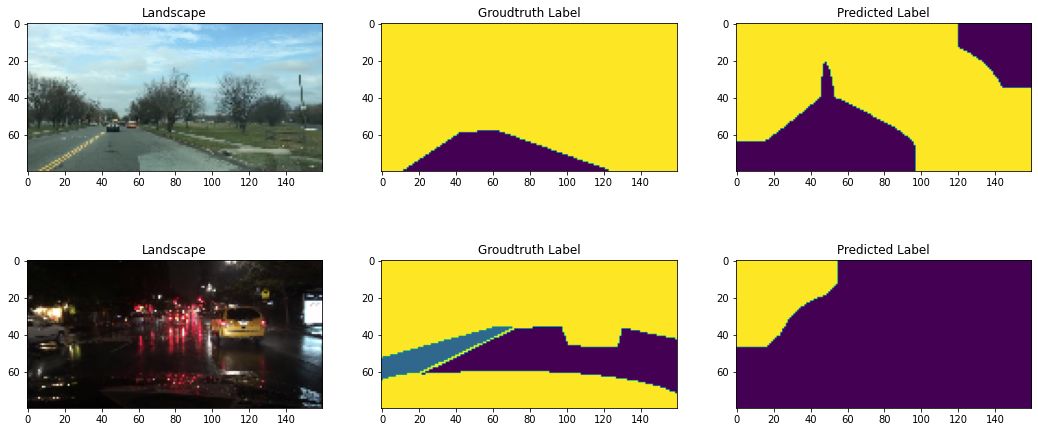

In [ ]:
visualizePredictions(model, test_dataset, gpu_device, numTestSamples =2)